In [1]:
!pip3 install PyTDC rdkit tensorflow mordred pandas scikit-learn numpy matplotlib



  Using cached pytdc-1.1.14.tar.gz (151 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached rdkit-2024.9.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.0 kB)
  Using cached tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached mordred-1.2.0.tar.gz (128 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached numpy-2.2.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB)
  Using cached dataclasses-0.6-py3-none-any.whl.metadata (3.0 kB)
  Using cached 

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tdc.single_pred import ADME




Converting smiles format to morgan fingerprints so regression models can be built

In [4]:
def mol_to_fp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits, dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [5]:
from tdc.single_pred import ADME
data_lipophilicity = ADME(name='Lipophilicity_AstraZeneca').get_data()

print(data_lipophilicity.head())

Found local copy...
Loading...
Done!


         Drug_ID                                               Drug     Y
0   CHEMBL596271            Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21  3.54
1  CHEMBL1951080  COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)... -1.18
2     CHEMBL1771              COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1  3.69
3   CHEMBL234951  O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...  3.37
4   CHEMBL565079  Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...  3.10


In [6]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem


X = np.array([mol_to_fp(s) for s in data_lipophilicity['Drug']])
y = data_lipophilicity['Y'].values  # Lipophilicity (logD)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
!pip3 install xgboost


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Can add more models if you want but I've already found this to be the best (and pretty fast)

models = {
    "XGBRegressor": {
        "model": XGBRegressor(random_state=33),
        "param_grid": {
            'n_estimators': [100, 300],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1],
        },
    },
}

best_models = {}
best_scores = {}
best_params = {}

for model_name, mp in models.items():
    print(f"=== Grid Search for {model_name} ===")
    grid_search = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["param_grid"],
        scoring='neg_mean_squared_error',  
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    
    best_estimator = grid_search.best_estimator_
    cv_mse = -grid_search.best_score_  

    # Evaluate on the test set
    y_pred_test = best_estimator.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    print("Best Parameters:", grid_search.best_params_)
    print("CV MSE:", cv_mse)
    print("Test RMSE:", test_rmse)
    print("")

    
    best_models[model_name] = best_estimator
    best_scores[model_name] = test_mse
    best_params[model_name] = grid_search.best_params_


best_model_name = min(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f"Best overall model: {best_model_name}")
print(f"Parameters: {best_params[best_model_name]}")
print(f"Test MSE: {best_scores[best_model_name]}")



=== Grid Search for XGBRegressor ===
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
CV MSE: 0.7249929928182406
Test RMSE: 0.8270083402648009

Best overall model: XGBRegressor
Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
Test MSE: 0.6839427948675406


**Testing and Metrics**

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test R^2:", r2_test)


Test MSE: 0.6839427948675406
Test MAE: 0.6108389077698148
Test R^2: 0.53708656180473


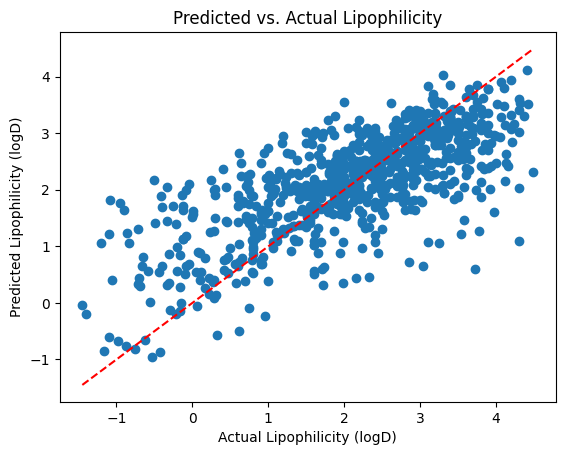

In [10]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_pred)
plt.xlabel("Actual Lipophilicity (logD)")
plt.ylabel("Predicted Lipophilicity (logD)")
plt.title("Predicted vs. Actual Lipophilicity")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()

In [11]:
test_smiles = "COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)CSCC(=O)O" 
test_smiles = mol_to_fp(test_smiles)

best_model.predict([test_smiles])

array([-1.1450794], dtype=float32)

Pretty good. Ground truth is -1.18

In [12]:
!pip3 install joblib



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [13]:
import joblib
import os

# Directory to save models
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Train and save models
for name, model_dict in models.items():
    model = model_dict["model"]
    model.fit(X_train, y_train)  # Train model (make sure X_train, y_train are defined)
    
    model_path = os.path.join(model_dir, f"{name}.pkl")
    joblib.dump(model, model_path)  # Save model
    print(f"Saved {name} to {model_path}")


Saved XGBRegressor to saved_models/XGBRegressor.pkl
